In [177]:
using Pkg

Pkg.activate("..")

using LinearAlgebra
using Distributions
using Random
using StatsBase


using ForwardDiff
using LambertW
using Roots 

using Graphs
using CairoMakie
using GraphMakie

using DelimitedFiles

include("../Code/MiNet.jl")

  Activating project at `~/Projects/Working/HIFMB/MiNet`


Main.MiNet

In [178]:
function plot_bifurcation!(ax, xvec, yvec; args...)
    if any(length.(yvec) .== 3)
        b_order = 0
        #if not all in the multistable
        if !all(length(yvec) .== 3)
            b_order = minimum(yvec[end]) < maximum(yvec[1]) ? :hl : :lh 
        else
            b_order = yvec[end][2] < yvec[1][2] ? :hl : :lh
        end
        
        #plot branches
        if b_order == :hl
            inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], maximum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], minimum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        elseif b_order == :lh
             inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], minimum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], maximum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        end
    else
        lines!(ax, xvec, [y[1] for y = yvec]; args...)
    end
end

plot_bifurcation! (generic function with 1 method)

# Introduction

# Poisson

In [223]:
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

#generate p_list
n_l = 2
l_vec = range(1.0, 10.0, length = n_l)
ρ = 0.0
p_mat = [([λn,λp, ρ*sqrt(λn*λp)], [λp,λn, ρ*sqrt(λn*λp)]) for λn = l_vec, λp = l_vec]

b0_sols = Matrix{Vector}(undef,n_l, n_l)
c0_sols = similar(b0_sols)

k = [0]

Threads.@threads for i = 1:n_l
    for j = 1:n_l
        k[1] += 1
        if k[1] % 100 == 0
            print("\r", k)
        end
        
        B(x) = F(x[1],x[2], p_mat[i,j][1])
        C(x) = F(x[1],x[2], p_mat[i,j][2])

        b0,c0 = MiNet.solve_arrival_probs(B,C)

        b0_sols[i,j] = b0 
        c0_sols[i,j] = c0 
    end
end

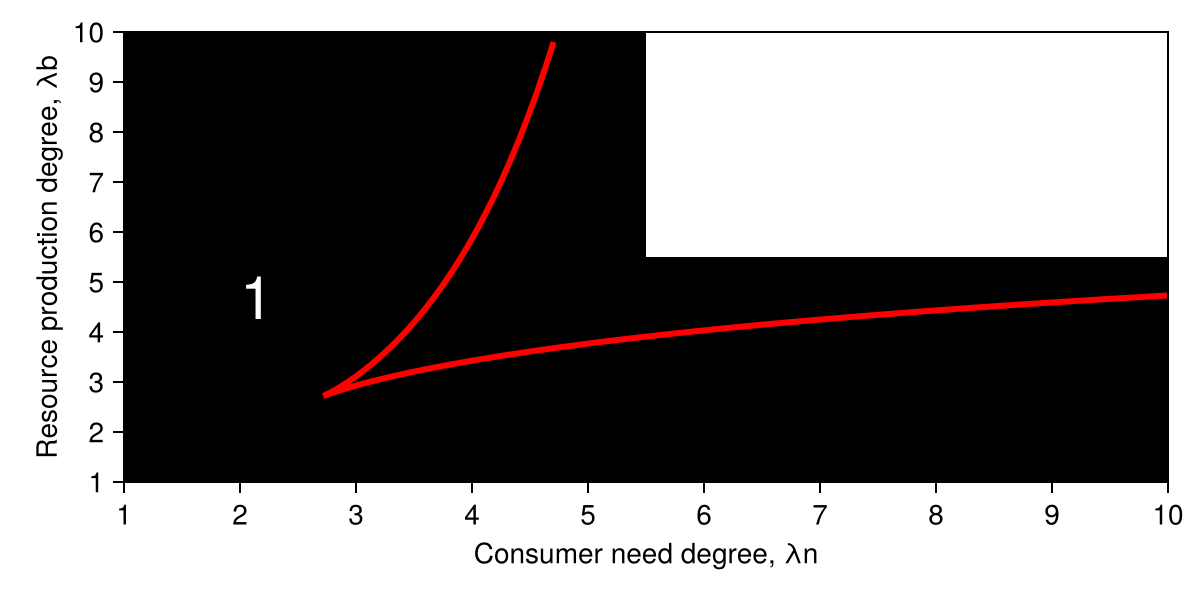

In [224]:
f = Figure(size = (600,300))
n_l = 100
l_vec = range(1.0, 10.0, length = n_l)
ax = Axis(f[1,1], xlabel = "Consumer need degree, λn", 
                  ylabel = "Resource production degree, λb")

#plot phase space
N_b0 = length.(b0_sols)
heatmap!(ax, l_vec, l_vec, N_b0, colormap = :greys)

#plot manifolds
λc = range(exp(1), 10.0, length = 100)
λb = hcat(MiNet.bifurcation_manifold.(λc)...)

ind = λb[1,:] .< 10.0
lines!(ax, λc[ind], λb[1,ind], color = "red", linewidth = 3)
lines!(ax, λc, λb[2,:], color = "red", linewidth = 3)

text!(ax, 2, 4, text = "1", color = "white", fontsize = 30)
text!(ax, 4, 4, text = "2", color = "black", fontsize = 30)

f

# Network simulations

Here we simulate networks and observe the bifurcation numerically. Dynamics on the large networks show the explosive transition between high and low diversity states.

In [16]:
include("../Code/MiNet.jl")

Random.seed!(1)
N = 10
Nl = 2
Nsamp = 1

λp,λr = .0, 0.0
l_vec_net = range(0.1, 5.0, length = Nl)

#allocate result matricies
sim_mat  = Array{Float64,3}(undef, length(l_vec_net), 2, Nsamp)
# init_s = zeros(length(l_vec_net), Nsamp)

#across need degree variation
k = [0]
Threads.@threads for l = eachindex(l_vec_net)
    k[1] += 1
    print("\r", k)
    λp = l_vec_net[l]
    λn = l_vec_net[l]
    c = vcat(fill(true, N), fill(false,N))
    
    #get simulated proportions persisting
    for i = 1:Nsamp
        #make network
        g = MiNet.generate_network(N,MiNet.joint_sample_cheat,λn,λp,λr);
        is = rand()
        s = MiNet.get_state(g, c, is, Nt = 1000)

        # init_s[l,i] = is
        sim_mat[l,1,i] = sum(s[1:N]) / N
        sim_mat[l,2,i] = sum(s[(N+1):end]) / N
    end
end

[2]

In [24]:
l_pred = range(extrema(l_vec_net)..., length = 25)
pred_mat = Array{Vector{Float64},2}(undef, length(l_pred), 2)
# #predictions
for l = eachindex(l_pred)
    λn = l_pred[l]
    F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))
    B(x) = F(x[1],x[2], [λn,λp,λr])
    C(x) = F(x[1],x[2], [λp,λn,λr])

    pred_vals = 0
    try
        pred_vals = MiNet.solve_arrivalnprobs(B,C)
    catch
        pred_vals =[[0.0],[0.0]]
    end
    pred_mat[l,1] = pred_vals[1]
    pred_mat[l,2] = pred_vals[2]
end

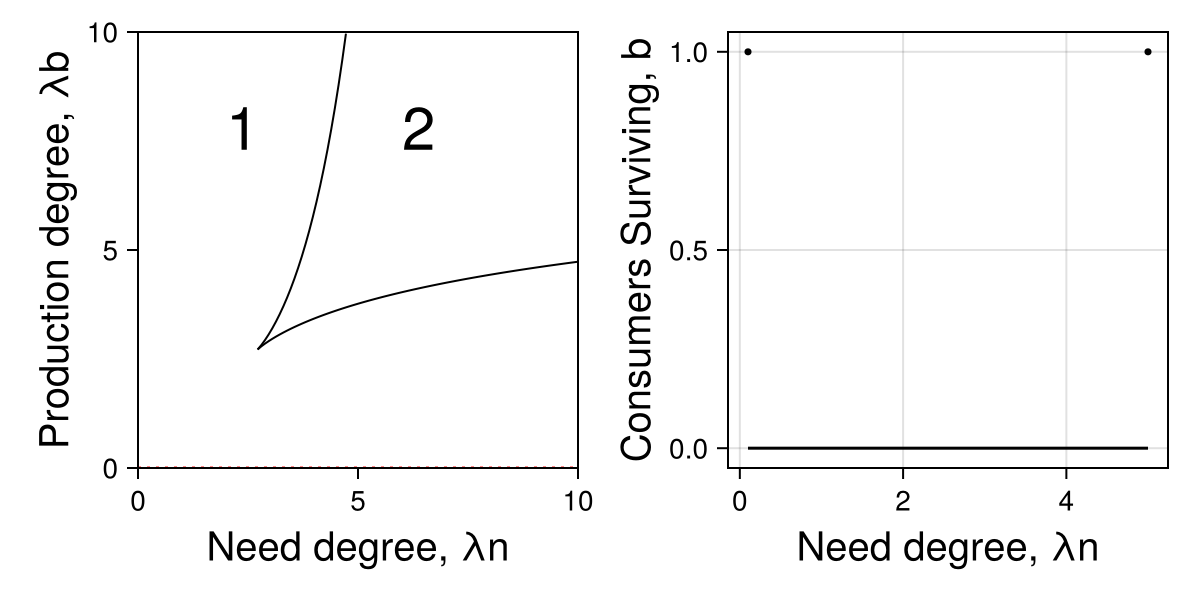

In [25]:
f = Figure(size = (600,300))

style = (xlabelsize = 20, ylabelsize = 20)

n_l = 200
l_vec = range(1.0, 10.0, length = n_l)
ax = Axis(f[1,1], xlabel = "Need degree, λn", 
                  ylabel = "Production degree, λb"; style...)

#plot phase space
N_b0 = length.(b0_sols)
# heatmap!(ax, l_vec, l_vec, N_b0, colormap = :Spectral)

#plot slice
hlines!(ax, λp, color = :red, linestyle = :dot)

#plot manifolds
λc = range(exp(1), 11.0, length = 100)
λb = hcat(MiNet.bifurcation_manifold.(λc)...)

ind = λb[1,:] .<= 10.0
lines!(ax, λc[ind], λb[1,ind], color = "black", linewidth = 1)

ind = λc .<= 10.0
lines!(ax, λc[ind], λb[2, ind], color = "black", linewidth = 1)

text!(ax, 2, 7, text = "1", color = "black", fontsize = 30)
text!(ax, 6, 7, text = "2", color = "black", fontsize = 30)

xlims!(ax, 0, 10)
ylims!(ax, 0, 10)

hidedecorations!(ax, label = false, ticklabels= false, ticks= false)

#plotting
ax = Axis(f[1,2], xlabel = "Need degree, λn", ylabel = "Consumers Surviving, b";style...)

plot_bifurcation!(ax, l_pred, pred_mat[:,1], color = :black)

for i = eachindex(l_vec_net)
    #sim
    y = sim_mat[i,1,:]
    x = fill(l_vec_net[i], length(y))
    # lb = quantile(y,0.05)
    # ub = quantile(y,0.95)
    # errorbars!(ax, [mean(x)],[mean(y)],[mean(y) - lb],[mean(y) - ub], color = "black")
    scatter!(ax, x ,y, markersize = 5, color = "black")
end

f

In [1014]:
# save("../Results/Figures/PhaseTrans.pdf", f)

CairoMakie.Screen{PDF}


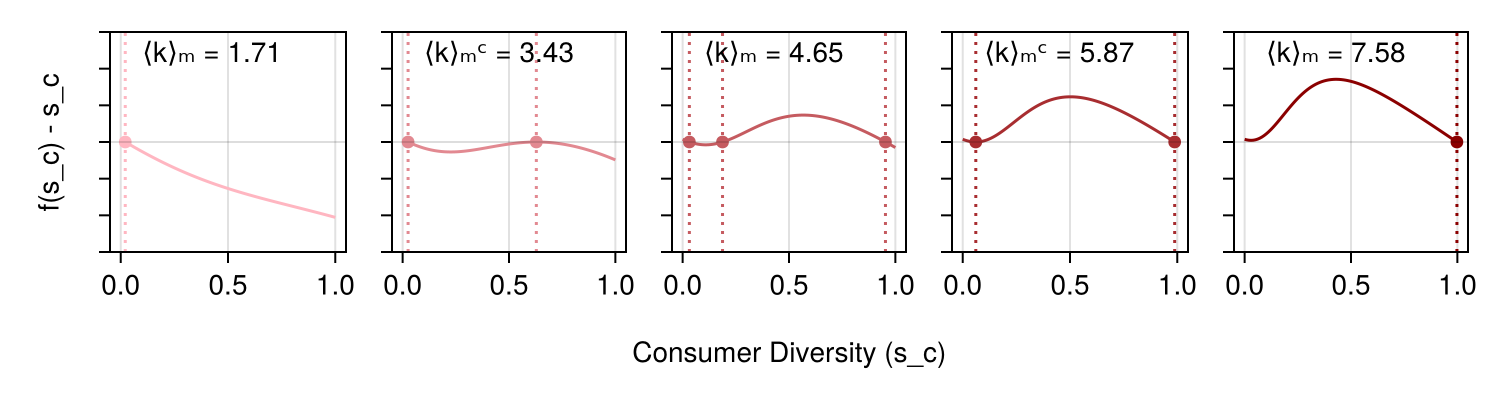

In [179]:
## bifurcation plot
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

λn = 4.0
#get critical points
λc_crit = MiNet.bifurcation_manifold(λn) |> sort

d = [λc_crit[1] / 2, λc_crit[1], mean(λc_crit), λc_crit[2],λc_crit[2] + λc_crit[1] / 2]

lc_vec = [[λn, l, 0.0] for l = d]
lm_vec = [[l, λn, 0.0] for l = d]

C_vec = [x -> F(x[1],x[2],l) for l = lc_vec]
M_vec = [x -> F(x[1],x[2],l) for l = lm_vec]



f = Figure(size = (750,200))
x_vec = range(0,1.0, length = 100)

for i = eachindex(d)
    ax = Axis(f[1,i])
    hidedecorations!(ax, grid = false, ticks = false,ticklabels=false)
    hideydecorations!(ax, ticks=false)
    f_sol = MiNet.arrival_prop_funcs.(C_vec[i], M_vec[i])
    b1(x) = f_sol[:b](f_sol[:c](x)) - x

    c = resample_cmap(:reds, length(d))[i]
    style = d[i] ∈ λc_crit ? :dash : :solid

    #find solutions
    y_vec = b1.(x_vec)
    lines!(ax, x_vec, y_vec, color = c)

    sol = find_zeros(b1, -0, 1)
    scatter!(ax, sol, fill(0.0,length(sol)), color = c)
    vlines!(ax, sol, color = c, linestyle = :dot)
    
    hlines!(ax, 0.0, color = :black, linewidth = 0.1)
    
    if d[i] ∉ λc_crit
        text!(ax, 0.1, 0.5, text = "⟨k⟩ₘ = $(round(d[i],digits = 2))")
    else
        text!(ax, 0.1, 0.5, text = "⟨k⟩ₘᶜ = $(round(d[i],digits = 2))")
    end

    ylims!(ax, -0.75,0.75)
end

linkyaxes!(f.content...)

Label(f[2,1:5],"Consumer Diversity (s_c)")
Label(f[1,0 ],"f(s_c) - s_c", rotation = pi/2, tellheight = false)

f



# Consumer and Resource Supply

Next we consider what happens as we supply consumer or resources in the system. This is equivelent to fixing some proportion of the nodes states as persisting. 

In [181]:
A(X, s) = s + (1-s)*X # remove proportion s / keep proportion (s-1)
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

λn=4.0
λp=10.0

#generate p_list
n_s = 100
s_vec = range(0.0, 0.99, length = n_s)
ρ = 0.0

# p_mat = [([λn,λp, ρ*sqrt(λn*λp)], [λp,λn, ρ*sqrt(λn*λp)]) for λn = l_vec, λp = l_vec]

b0_s_sols = Matrix{Vector}(undef,n_s, n_s)
c0_s_sols = similar(b0_s_sols)

k = [0]

Threads.@threads for i = 1:n_s
    for j = 1:n_s
        
        k[1] += 1
        if k[1] % 100 == 0
            print("\r", k)
        end

        #remove eb - 1 species
        eb = s_vec[i]
        #supply ec resources
        ec = s_vec[j]

        B(x) = F(A(x[1], ec), A(x[2], ec),  [λn,λp,0.0]) 
        C(x) = F(A(x[1], eb), A(x[2], eb),  [λp,λn,0.0]) 

        b0,c0 = MiNet.solve_arrival_probs(B,C)
        
        
        b0_s_sols[i,j] = b0 
        c0_s_sols[i,j] = c0
    
    end
end

LoadError: cannot define function A; it already has a value

In [182]:
f = Figure(size = (1200,600))
ax = Axis(f[1,1], xlabel = "consumers removed", ylabel = "resources supplied")
axm = [Axis(f[1,1 + i]) for i = 1:3]

n_s = 100
s_vec = range(0.0, 0.99, length = n_s)


for i = 1:n_s
    for j = 1:n_s
        if length(b0_s_sols[i,j]) == 1
            scatter!(ax,s_vec[i], s_vec[j], color = b0_s_sols[i,j][1],colorrange = (0,1))
        else
            for k = 1:3
                scatter!(axm[k],s_vec[i],s_vec[j],color = b0_s_sols[i,j][k],colorrange = (0,1))
            end
        end
    end
end

ax = Axis(f[2,1], xlabel = "consumers removed", ylabel = "resources supplied")
axm = [Axis(f[2,1 + i]) for i = 1:3]

n_s = 100
s_vec = range(0.0, 0.99, length = n_s)

for i = 1:n_s
    for j = 1:n_s
        if length(b0_s_sols[i,j]) == 1
            scatter!(ax,s_vec[i],s_vec[j], color = c0_s_sols[i,j][1],colorrange = (0,1))
        else
            for k = 1:3
                scatter!(axm[k],s_vec[i],s_vec[j],color = c0_s_sols[i,j][k],colorrange = (0,1))
            end
        end
    end
end


linkaxes!(f.content...)

f

LoadError: UndefVarError: `b0_s_sols` not defined

In [873]:


# f = Figure()
# ax1 = Axis(f[1,1], title = "Consumers persisting")
# ax2 = Axis(f[1,2], title = "Resources persisting")

# Label(f[2,1:2], "Consumers Removed", tellheight = true)

# ax3 = Axis(f[3,1])
# ax4 = Axis(f[3,2])

# Label(f[4,1:2], "Resources Supplied", tellheight = true)


# for i = 1:20:n_s
#     yvec = b0_s_sols[:,i]
#     color = 1
    
#     plot_bifurcation!(ax1, s_vec, b0_s_sols[:,i], color = i, colorrange = (1,n_s))
#     plot_bifurcation!(ax2, s_vec, c0_s_sols[:,i], color = i, colorrange = (1,n_s))

#     plot_bifurcation!(ax3, s_vec, b0_s_sols[i,:], color = i, colorrange = (1,n_s))
#     plot_bifurcation!(ax4, s_vec, c0_s_sols[i,:], color = i, colorrange = (1,n_s))

# end
#     f

## supply simulations

In [878]:
#network size
N = 5000
#average degree: need produce covariance
λn,λp,λr = 4.0, 10.0, 0.0

n_r = 10

#create network and set initial state
g = MiNet.generate_network(N, λn,λp,λr);
c = fill(false, 2N)
c[1:N] .= true
s = fill(true, 2N);

b0_sim_sols = Array{Float64,3}(undef,n_s, n_s, n_r)
c0_sim_sols = similar(b0_sim_sols)

#create network and set initial state
g = MiNet.generate_network(N, λn,λp,λr);
c = fill(false, 2N)
c[1:N] .= true
s = fill(true, 2N);

rep = [0]
Threads.@threads for i = 1:n_s
    for j = 1:n_s

        c_copy = deepcopy(c)
        g_copy = deepcopy(g)
        
        k[1] += 1
        if k[1] % 100 == 0
            print("\r", k)
        end

        b_rm = sample(1:N, Int(floor(s_vec[i]*N)), replace = false)
        c_rm = sample(N+1:2N, Int(floor(s_vec[j]*N)), replace = false)

        to_rm = vcat(b_rm, c_rm)
        to_keep = filter( x -> x ∉ to_rm, 1:2N)

        rem_vertices!(g_copy, to_rm, keep_order = true)
        c_copy = c_copy[to_keep]
    
        for r = 1:n_r
            s = MiNet.get_state(g_copy, c_copy, rand(); Nt = 100, ts = false)
            b0_sim_sols[i,j,r] = mean(s[c_copy])
            c0_sim_sols[i,j,r] = mean(s[.!c_copy])
        end
    end
end

[69600]

# Plotting

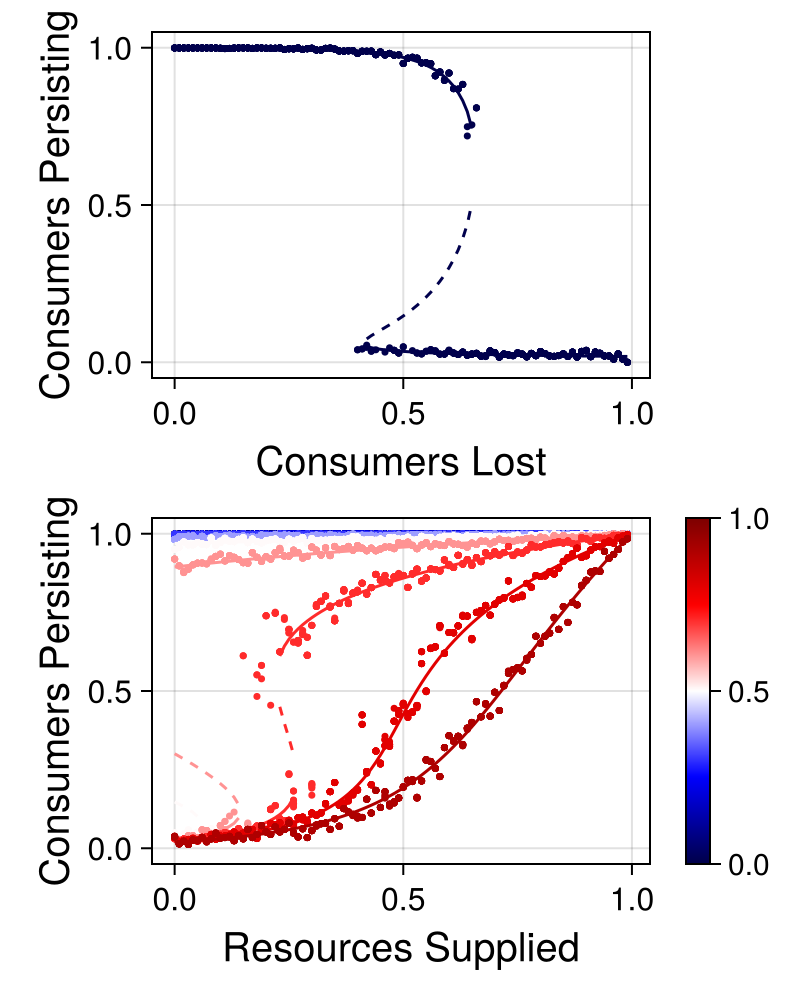

In [1022]:
f = Figure(size = (400,500))

style = (xlabelsize = 20, ylabelsize = 20, xticklabelsize = 16, yticklabelsize = 16)

ax = Axis(f[1,1], xlabel = "Consumers Lost", ylabel = "Consumers Persisting"; style...)

#initial consumer bifurcation
c = resample_cmap(:seismic, n_s)[1]
series!(ax, s_vec, b0_sim_sols[:,1,:]', solid_color = c, linewidth = 0, markersize = 5)
plot_bifurcation!(ax, s_vec, b0_s_sols[:,1], color = c)


#varying consumer supply
ax2 = Axis(f[2,1], xlabel = "Resources Supplied", ylabel = "Consumers Persisting", ; style...)
for i = 1:10:n_s
    c = resample_cmap(:seismic, n_s)[i]
    
    series!(ax2, s_vec, b0_sim_sols[i,:,:]'  , solid_color = c, linewidth = 0, markersize = 5)

    plot_bifurcation!(ax2, s_vec, b0_s_sols[i,:], color = c)
end
Colorbar(f[2,2], colormap = :seismic, colorrange = (0,1), ticklabelsize = 15)

linkaxes!(ax,ax2)

# save("../Results/Figures/removal_plots.pdf", f)

f

# Network Plot

In [41]:
Random.seed!(2)

N = 100

λn,λp,λr = 1.0,2.0,0.0

g = MiNet.generate_network(N,MiNet.joint_sample_cheat, λn,λp,λr);
c = vcat(fill(true, N), fill(false,N))
s = sl = MiNet.get_state(g, c, 0.7)

cond_ind = connected_components(g)[1]
rem_vertices!(g, findall(1:2N .∉ Ref(cond_ind)), keep_order = true)

s = s[cond_ind]
c = c[cond_ind]

MiNet.graphviz(g,s,c,"../Results/graphs/graph.dot", "../Results/Figures/graph.pdf")


Process(`dot -Tpdf ../Results/graphs/graph.dot`, ProcessExited(0))

In [42]:
include("../Code/MiNet.jl")
MiNet.graphviz_bipartite(g,s,c,"../Results/graphs/graph.dot", "../Results/Figures/graph_bi.pdf")

0.0
0
0.10752688172043012
0
0.21505376344086025
0
0.3225806451612903
0
0.4301075268817205
0
0.5376344086021505
0
0.6451612903225806
0
0.7526881720430108
0
0.860215053763441
0
0.967741935483871
0
1.075268817204301
0
1.1827956989247312
0
1.2903225806451613
0
1.3978494623655913
0
1.5053763440860215
0
1.6129032258064515
0
1.720430107526882
0
1.827956989247312
0
1.935483870967742
0
2.043010752688172
0
2.150537634408602
0
2.258064516129032
0
2.3655913978494625
0
2.4731182795698925
0
2.5806451612903225
0
2.6881720430107525
0
2.7956989247311825
0
2.903225806451613
0
3.010752688172043
0
3.118279569892473
0
3.225806451612903
0
3.333333333333333
0
3.440860215053764
0
3.548387096774194
0
3.655913978494624
0
3.763440860215054
0
3.870967741935484
0
3.978494623655914
0
4.086021505376344
0
4.193548387096774
0
4.301075268817204
0
4.408602150537634
0
4.516129032258064
0
4.623655913978494
0
4.731182795698925
0
4.838709677419355
0
4.946236559139785
0
5.053763440860215
0
5.161290322580645
0
5.2688172043010

Process(`dot -Tpdf ../Results/graphs/graph.dot`, ProcessExited(0))